## Dependencies

In [1]:
import os
import sys
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append("/workspaces/talento_tech/ingest/")
import config  # type: ignore

## Dataset

In [2]:
db_dir = config.Database.dir
db_filename = config.Database.filename
db_path = os.path.join(db_dir, db_filename)

ddb = duckdb.connect(database=db_path)

## DataFrames

In [3]:
df_imports = ddb.sql(
    """SELECT cmdCode, primaryValue 
    FROM korea_imports
    WHERE partnerDesc = 'World';
    """
).df()

df_imports_colombia = ddb.sql(
    """SELECT cmdCode, primaryValue
    FROM korea_imports
    WHERE partnerDesc = 'Colombia';
    """
).df()

dfs = [df_imports, df_imports_colombia]

In [4]:
ddb.close()

## Standarized Data

In [5]:
scaler = StandardScaler()

In [6]:
for df in dfs:
    df[["cmdCode_T", "primaryValue_T"]] = scaler.fit_transform(df[["cmdCode", "primaryValue"]])

In [7]:
df_imports.describe()

,cmdCode,primaryValue,cmdCode_T,primaryValue_T
count,1214.000000,1.214000e+03,1.214000e+03,1.214000e+03
mean,52.883031,5.282019e+08,-1.170581e-17,8.779358e-18
std,27.650024,3.386437e+09,1.000412e+00,1.000412e+00
min,1.000000,2.000000e+00,-1.877192e+00,-1.560400e-01
25%,28.000000,1.120104e+07,-9.002989e-01,-1.527310e-01
50%,53.500000,5.917293e+07,2.232269e-02,-1.385593e-01
75%,81.000000,2.413559e+08,1.017307e+00,-8.473930e-02
max,99.000000,8.615842e+10,1.668569e+00,2.529665e+01


In [8]:
df_imports_colombia.describe()

,cmdCode,primaryValue,cmdCode_T,primaryValue_T
count,244.00000,2.440000e+02,2.440000e+02,2.440000e+02
mean,55.29918,4.377155e+06,-2.912060e-17,-3.640075e-18
std,26.70161,4.825832e+07,1.002056e+00,1.002056e+00
min,1.00000,2.000000e+00,-2.037735e+00,-9.088900e-02
25%,33.00000,1.817500e+02,-8.368415e-01,-9.088526e-02
50%,61.00000,2.328500e+03,2.139398e-01,-9.084069e-02
75%,84.00000,3.482675e+04,1.077082e+00,-9.016588e-02
max,97.00000,7.363070e+08,1.564944e+00,1.519809e+01


## Find Optimum Number of Clusters

In [9]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

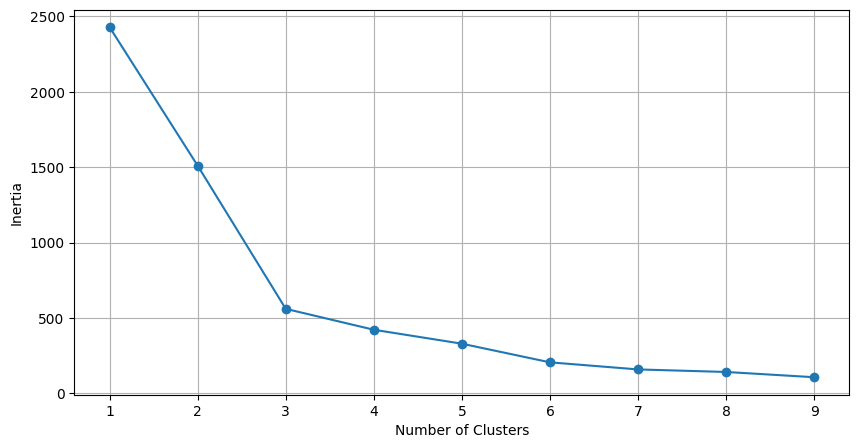

In [10]:
optimize_k_means(df_imports[["cmdCode_T", "primaryValue_T"]], 10)

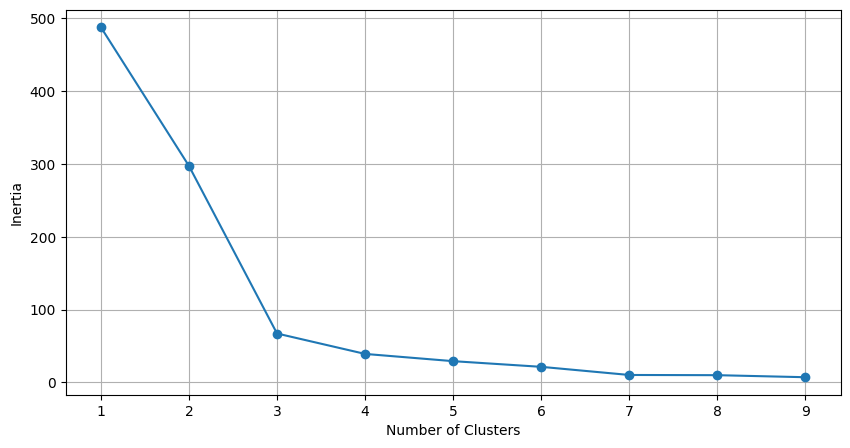

In [11]:

optimize_k_means(df_imports_colombia[["cmdCode_T", "primaryValue_T"]], 10)

## Model

In [12]:
kmeans_imports = KMeans(n_clusters=5)
kmeans_imports_colombia = KMeans(n_clusters=4)

In [13]:
kmeans_imports.fit(df_imports[["cmdCode_T", "primaryValue_T"]])
kmeans_imports_colombia.fit(df_imports_colombia[["cmdCode_T", "primaryValue_T"]])

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [14]:
df_imports["kmeans"] = kmeans_imports.labels_
df_imports_colombia["kmeans"] = kmeans_imports_colombia.labels_

## Plot Result

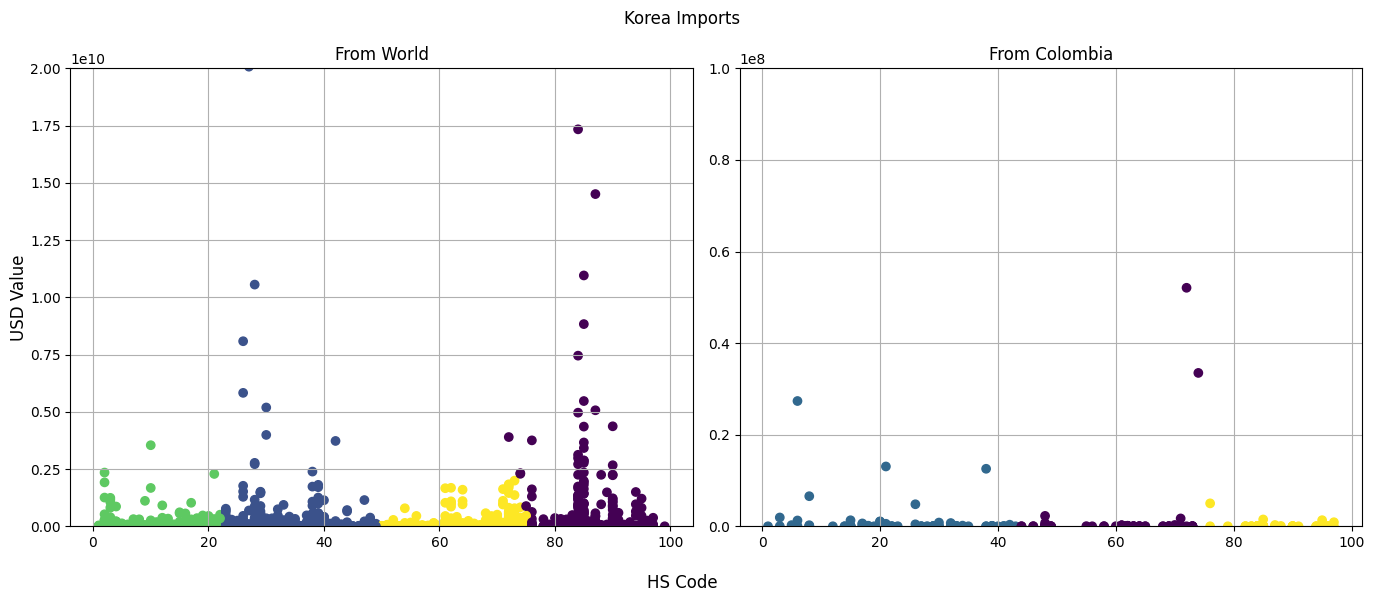

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
ax1, ax2 = fig.axes

ax1.scatter(x=df_imports["cmdCode"], y=df_imports["primaryValue"], c=df_imports["kmeans"])
ax1.grid(True)
ax1.set_title("From World")
ax1.set_ylim(0, 2e10)

ax2.scatter(x=df_imports_colombia["cmdCode"], y=df_imports_colombia["primaryValue"], c=df_imports_colombia["kmeans"])
ax2.grid(True)
ax2.set_title("From Colombia")
ax2.set_ylim(0, 1e8)


fig.suptitle("Korea Imports")
fig.supylabel("USD Value")
fig.supxlabel("HS Code")
fig.tight_layout()
plt.show()